In [1]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def generateCandidates(Ti,l):
    Wil = [np.array(Ti[i : i + l]) for i in range(0, len(Ti)-l+1, 1)]
    return Wil

In [3]:
def create_Wl(T,l):
    return [generateCandidates(Ti,l) for Ti in T]

In [4]:
def findDistances(S,Wl):
    Ds = [cdist(np.array([S]),np.vstack(Wil),metric='seuclidean').min() for Wil in Wl]
    return np.array(Ds)

In [5]:
def assessCandidate(S,Ds,C):
    class_groups = [Ds[C==c].tolist() for c in np.unique(C)]

#     plt.figure(figsize=(10,5))
#     colors = np.array(['red','blue','green'])
#     for c in np.unique(C):
#         sns.distplot(x=Ds[C==c],color= colors[c])
    
    return f_oneway(*class_groups).statistic

In [6]:
def sortByQuality(shapelets):
    return sorted(shapelets, key=lambda tup: tup[1],reverse=True)

In [7]:
def removeSelfSimilar(shapelets):
    queue = shapelets[:]
    df = pd.DataFrame(shapelets)

    keep_df = pd.DataFrame()

    while len(df) != 0:
        pop_item = queue.pop(0)
        s,f,interval = pop_item

        keep_df = pd.concat((keep_df,pd.DataFrame([pop_item])))

        df = df[~df[2].apply(lambda x: interval.overlaps(x))]
        queue = df.values.tolist()
    
    return keep_df.drop(2,axis=1).values.tolist()

In [8]:
def merge(k,kShapelets,shapelets):
    total_shapelets = kShapelets + shapelets
    return sortByQuality(total_shapelets)[:k]

In [9]:
def ShapeletCachedSelection(T,lmin,lmax,k):
    precompute_Wl = {l : create_Wl(T,l) for l in np.arange(lmin,lmax+1)}
    kShapelets = []
    for i,Ti in enumerate(tqdm(T)):
        shapelets = []
        for l in np.arange(lmin,lmax+1):
            Wl = precompute_Wl[l]
            for index,S in enumerate(Wl[i]):
                Ds = findDistances(S,Wl)
                quality = assessCandidate(S,Ds,C)
                shapelets.append((S,quality,pd.Interval(index,index+l,closed='both')))
        shapelets = sortByQuality(shapelets)
        shapelets = removeSelfSimilar(shapelets) 
        kShapelets = merge(k,kShapelets,shapelets)
        
    plt.figure(figsize=(10,10))
    sns.boxplot(y=Ds,x=C)
    plt.title("Example of Discriminatory Shapelet Power. F Score: " + str(quality) + " Train Example: "+str(i))
    return kShapelets

In [10]:
def generate_dataset(N,min_l,max_l):
    U = np.random.rand(N)
    classes = []
    for i in np.arange(3):
        classes.append(np.sum((U <= (i+1)*1/3) & (U > i*1/3) ))
    
    D = []
    for i,nc in enumerate(classes):
        for _ in np.arange(nc):
            size = np.random.randint(min_l,max_l+1,1)[0]
            x = np.linspace(0,1,size)
            noise = np.random.normal(0,0.1,size)
            if i == 0:
                D.append( noise +  (1.5 * x ))
            if i == 1:
                D.append( 3*(np.sin(x*(np.pi)*3)) + noise )
            if i == 2:
                #D.append( 1/100 * np.arange(np.random.randint(min_l,max_l+1,1))**3 )
                D.append( noise +  (2*np.log(x*25+1) ))

    C = [0]*classes[0] + [1] * classes[1] + [2] * classes[2]
    C = np.array(C)
    
    return D,C

In [11]:
N = 200
N_test = 5000
lmin = 7
lmax = 15
k = 100

min_seq_len = 20
max_seq_len = 30
T,C = generate_dataset(N,min_seq_len,max_seq_len)
T_test,C_test = generate_dataset(N_test,min_seq_len,max_seq_len)

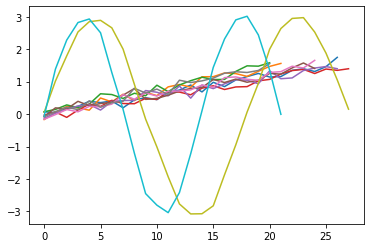

In [12]:
for Ti in T[slice(1,100,10)]:
    plt.plot(Ti)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:21<00:00,  1.91s/it]


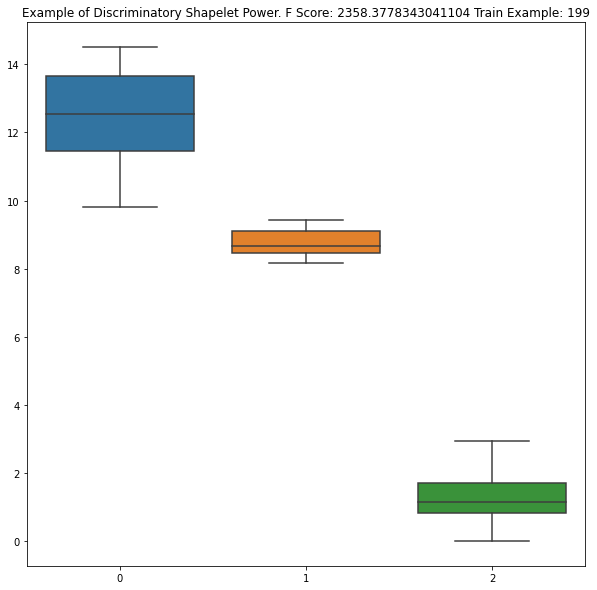

In [16]:
kshapelets = ShapeletCachedSelection(T,lmin,lmax,k)

Text(0.5, 1.0, 'Training Trajectories')

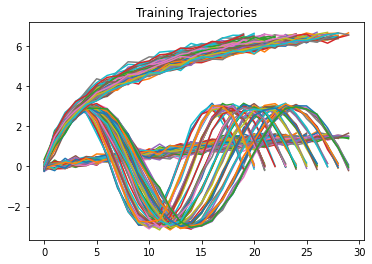

In [17]:
for Ti in T:
    plt.plot(Ti)
plt.title("Training Trajectories")

Text(0.5, 1.0, 'Discriminatory Shapelets')

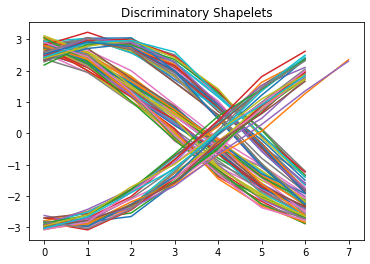

In [28]:
for shape in kshapelets:
    plt.plot(shape[0])
plt.title("Discriminatory Shapelets")

In [21]:
feature_shaplets,quality_scores = zip(*kshapelets)

In [22]:
dataset = np.zeros((N,k))
for i,feature in enumerate(tqdm(feature_shaplets)):
    l = len(feature)
    Wl = create_Wl(T,l)
    Ds = findDistances(feature,Wl)
    dataset[:,i] = Ds

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.34it/s]


In [23]:
dataset_test = np.zeros((N_test,k))
for i,feature in enumerate(tqdm(feature_shaplets)):
    l = len(feature)
    Wl = create_Wl(T_test,l)
    Ds = findDistances(feature,Wl)
    dataset_test[:,i] = Ds

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [25]:
sc = StandardScaler()
model = LogisticRegressionCV().fit(sc.fit_transform(dataset),C)

In [26]:
print(classification_report(C,model.predict(sc.transform(dataset))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [27]:
print(classification_report(C_test,model.predict(sc.transform(dataset_test))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1677
           1       1.00      1.00      1.00      1608
           2       1.00      1.00      1.00      1715

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

